In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from pathlib import Path
from itertools import combinations
from matplotlib.font_manager import findSystemFonts, fontManager
from fd_analysis.prepare import filter_corrupt_files, get_depsfiles, get_parser_choices

font_path ='/usr/share/fonts/Virgil.ttf' 

# Register the font
fontManager.addfont(font_path)
fonts = set(f.name for f in fontManager.ttflist)

In [2]:
# import Biomedical's data

paths = "../data/biomedical_0.13.1.1/"

data_biomed, corrupt_biomed = filter_corrupt_files([Path(paths) / file for file in os.listdir(paths)])

print("Corrupt: ", corrupt_biomed)
len(data_biomed)

Corrupt:  []


1863

In [3]:
# import PyPI data

# paths = "../data/pypi_0.13.1.1/"
paths = "../data/results_pypi_20240423/"

data_pypi, corrupt_pypi = filter_corrupt_files([Path(paths) / file for file in os.listdir(paths)])

print("Corrupt: ", corrupt_pypi)
len(data_pypi)

Corrupt:  []


1160

In [4]:
# Example data with no Python code - written in R
data_biomed["markerGeneProfile.json"]

{'metadata': {'project_name': 'markerGeneProfile',
  'fawltydeps_version': '0.13.1.1',
  'repo_url': 'https://:@github.com/PavlidisLab/markerGeneProfile.git',
  'creation_timestamp': '2024-01-29T12:23:58.575464'},
 'code_dirs': None,
 'deps_file': [],
 'imports': []}

## Explore types of dependency declaration

### Identify Python projects

1473/1863 are Python projects
785/1473 have dependency declaration file present

In [5]:
785/1473


0.5329260013577732

In [6]:
depsfiles_biomed = get_depsfiles(data_biomed)
depsfiles_pypi = get_depsfiles(data_pypi)
{d["parser_choice"] for k, dd in depsfiles_biomed.items() for d in dd if d["deps_count"] > 0}

784
1132


{'pyproject.toml', 'requirements.txt', 'setup.cfg', 'setup.py'}

In [7]:
785/1473


0.5329260013577732

In [8]:
parser_choices_biomed = get_parser_choices(depsfiles_biomed)
parser_choices_pypi = get_parser_choices(depsfiles_pypi)    

In [9]:
requirements_declaration_methods_biomed_df = pd.DataFrame.from_dict(
    parser_choices_biomed, orient="index").sort_values(by="requirements.txt", ascending=False) > 0

requirements_declaration_methods_pypi_df = pd.DataFrame.from_dict(
    parser_choices_pypi, orient="index").sort_values(by="requirements.txt", ascending=False) > 0


In [10]:
def get_declaration_files_dictionary(requirements_declaration_methods_df):
    set_requirements = set(requirements_declaration_methods_df[requirements_declaration_methods_df["requirements.txt"]].index)
    set_pyproject_toml = set(requirements_declaration_methods_df[requirements_declaration_methods_df["pyproject.toml"]].index)
    set_setup_py= set(requirements_declaration_methods_df[requirements_declaration_methods_df["setup.py"]].index)
    set_setup_cfg= set(requirements_declaration_methods_df[requirements_declaration_methods_df["setup.cfg"]].index)


    requirements_sets = {"requirements.txt": set_requirements,
                "pyproject.toml": set_pyproject_toml,
                "setup.py": set_setup_py,
                "setup.cfg": set_setup_cfg}
    
    return requirements_sets
# venny4py.venny4py(sets={"requirements.txt": set_requirements, "pyproject.toml": set_pyproject_toml, "setup.py": set_setup_py, "setup.cfg": set_setup_cfg})

In [11]:
def convert2bars(declaration_files_dictionary, norm):
    data4bars =  declaration_files_dictionary | \
                    {f"{k1} & {k2}": v1 & v2 for (k1,v1), (k2,v2) in combinations(declaration_files_dictionary.items(), 2)} |\
                    {f"{k1} & {k2} & {k3}": v1 & v2 & v3 for (k1,v1), (k2,v2), (k3,v3) in combinations(declaration_files_dictionary.items(), 3)} |\
                    {f"all": v1 & v2 & v3 & v4 for (_,v1), (_,v2), (_,v3), (_,v4) in combinations(declaration_files_dictionary.items(), 4)}
    
    ddd = {k: np.round(len(v)/norm * 100) for k, v in data4bars.items()}
    return ddd
                
bars_biomed = convert2bars(get_declaration_files_dictionary(requirements_declaration_methods_biomed_df), norm=785)
bars_pypi = convert2bars(get_declaration_files_dictionary(requirements_declaration_methods_pypi_df), norm=573)
len(bars_biomed), len(bars_pypi)

(15, 15)

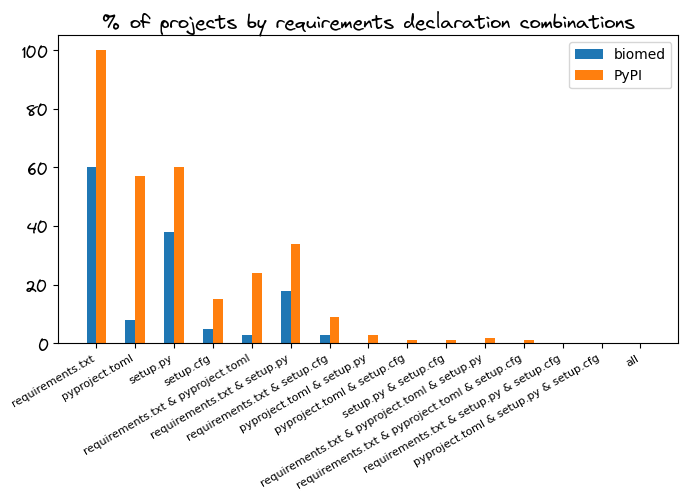

In [12]:

# plot bar plot based on data4bars

fig, ax = plt.subplots()
plt.yticks(fontname='Virgil 3 YOFF', fontsize=12)
plt.title('% of projects by requirements declaration combinations', fontname='Virgil 3 YOFF', fontsize=14)

r=np.arange(15)
width=0.25
# set figure sizxe
fig.set_size_inches(8, 4)
# rotate x ticks
plt.xticks(r+width/2, bars_biomed.keys(), rotation=30, ha='right', fontsize=8)
ax.bar(r,  bars_biomed.values(), label="biomed", width=width)
#make second bars adjascent to the first
ax.bar(r+width, bars_pypi.values(), label="PyPI", width=width)
plt.legend()